# Project 3  -  N layer Deep Neural Network Model

![](https://raw.githubusercontent.com/rishabhdhayal/Deep-Learning/main/images/Dribbble%20shot%20-%205.svg)

### Import Libraries  

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage


np.random.seed(3)

# Import Data

In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

### Let's check the image

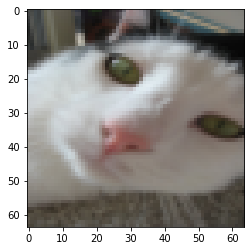

In [4]:
plt.imshow(train_x_orig[14])

#  Check The data dimensions

In [5]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


# Flatten The data

In [6]:
train_x_f = train_x_orig.reshape(train_x_orig.shape[0],-1).T
train_x_f.shape

(12288, 209)

In [7]:
test_x_f = test_x_orig.reshape(test_x_orig.shape[0],-1).T
test_x_f.shape

(12288, 50)

# Standardize the data

In [8]:
train_x = train_x_f/255
test_x = test_x_f/255

# Model Important Functions

### Initializing Parameters

In [9]:
def initialize_parameters(layers_dim):
    
    np.random.seed(3)
    
    parameters = {}
    L = len(layers_dim)
    
    for i in range(1,L):
        parameters["W" + str(i)] = np.random.randn(layers_dim[i],layers_dim[i-1])/ np.sqrt(layers_dim[i-1])
        parameters["b" + str(i)] = np.zeros((layers_dim[i],1))
        
    return parameters

## Activation Functions

In [10]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):

    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


### Linear Forward

In [11]:
def linear_forward(A,W,b):
    
#     Z = np.dot(W,A) + b
    Z = W.dot(A) + b
    
    cache = (A,W,b)
    
    return Z, cache

### Linear Activation

In [12]:
def linear_activation_forward(A_prev, W, b, activation):
    
    Z , linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "relu":
        A, activation_cache = relu(Z)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
        
    return A, cache

### L Layer forward

In [13]:
def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for i in range(1,L):
        A_prev = A
        
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)] , "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)] , "sigmoid")
    caches.append(cache)
    
    return AL, caches

### Compute cost

In [14]:
def compute_cost(AL,Y):
    
    m = Y.shape[1]
    
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)
    return cost

### Linear backward

In [15]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1./m)*np.dot(dZ,A_prev.T)
    db = (1./m)*np.sum(dZ,axis = 1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

### Linear Activation Backward

In [16]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ =  relu_backward(dA, activation_cache)

    elif activation == "sigmoid":
        dZ =  sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ,linear_cache)  
    
    return dA_prev, dW, db

### L layer backword

In [17]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

### Update Parameters

In [22]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

# Model

In [23]:
layers_dims = [12288,20,7,5,1]

In [24]:
def deep_layer_model(X,Y,layer_dims,learning_rate,iterations):
    
    np.random.seed(22)
    
    m = Y.shape[1]
    
    parameters = initialize_parameters(layer_dims)
    
    for i in range(0,iterations):
        
        AL, caches = L_model_forward(X, parameters)
        
        cost =  compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches) 
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 100 == 0 or i == iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    return parameters, cost
        

In [25]:
parameters, costs = deep_layer_model(train_x, train_y, layers_dims,0.0075, iterations = 2500,)


Cost after iteration 0: 0.7157315134137129
Cost after iteration 100: 0.6747377593469114
Cost after iteration 200: 0.6603365433622127
Cost after iteration 300: 0.6462887802148751
Cost after iteration 400: 0.6298131216927771
Cost after iteration 500: 0.606005622926534
Cost after iteration 600: 0.5690041263975134
Cost after iteration 700: 0.519796535043806
Cost after iteration 800: 0.4641571678628229
Cost after iteration 900: 0.40842030048298916
Cost after iteration 1000: 0.3731549921606904
Cost after iteration 1100: 0.3057237457304713
Cost after iteration 1200: 0.2681015284774085
Cost after iteration 1300: 0.2387247482767256
Cost after iteration 1400: 0.20632263257914704
Cost after iteration 1500: 0.17943886927493516
Cost after iteration 1600: 0.15798735818801024
Cost after iteration 1700: 0.14240413012273687
Cost after iteration 1800: 0.1286516599788459
Cost after iteration 1900: 0.11244314998151543
Cost after iteration 2000: 0.08505631034959686
Cost after iteration 2100: 0.057583911986

In [26]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [27]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9952153110047844


In [28]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78
